In [0]:
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
import numpy as np

% matplotlib inline
np.random.seed(2017)

from keras import regularizers
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dropout, GlobalAveragePooling2D, Input, Dense
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.callbacks import Callback
# Importing the callbacks of Keras.
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import cifar10
from keras import backend as K

Using TensorFlow backend.


In [3]:
# Mounting the Google Drive to save the weights
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
BATCH_SIZE = 128 #@param ["512", "256", "128"] {type:"raw"}
MOMENTUM = 0.9 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
WEIGHT_DECAY = 5e-4 #@param ["0.000125", "0.00025", "0.0005", "5e-4"] {type:"raw"}
LEARNING_RATE = 0.1 #@param ["0.4", "0.2", "0.1"] {type:"raw"}
EPOCHS = 300 #@param {type:"slider", min:0, max:300, step:1}
WARMUP = 5 #@param {type:"slider", min:0, max:24, step:1}

In [5]:
# CIFAR10 dataset 
#There are 50000 training images and 10000 test images. 
#Importing CIFAR10 dataset from Keras.
from keras.datasets import cifar10

# Loading the CIFAR10 60000 Training and 10000 Test images
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

n_train, n_test = X_train.shape[0], X_test.shape[0]
img_size = X_train.shape[1]
n_classes = y_train.max() + 1

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # Summarize for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(validation_iterator, test_y, model):
    result = model.evaluate_generator(validation_iterator, steps = len(validation_iterator))
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def show_examples(X,y,classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y[idx])])
    plt.show()

In [0]:
def get_cifar10_labels():
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [0]:
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

In [0]:
def get_cutout_eraser_and_padcrop(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True, random_crop_size=(32, 32), padding_pixels=4):
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img
     
    def random_crop(input_image):
          # Note: image_data_format is 'channel_last'
          assert input_image.shape[2] == 3
          
          #Pad by 4 pixels
          img = cv2.copyMakeBorder(input_image, padding_pixels, padding_pixels, padding_pixels, padding_pixels, cv2.BORDER_REPLICATE)
          
          height, width = img.shape[0], img.shape[1]
          dy, dx = random_crop_size
          x = np.random.randint(0, width - dx + 1)
          y = np.random.randint(0, height - dy + 1)
          return img[y:(y+dy), x:(x+dx), :]
        
    def preproc_image(input_image):
      #return eraser
      return eraser(random_crop(input_image))

    return preproc_image

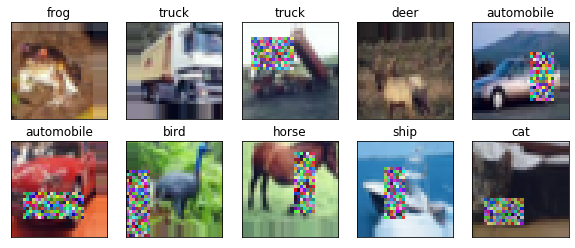

In [13]:
datagen = ImageDataGenerator(
   featurewise_center=True,
   featurewise_std_normalization=True,
   horizontal_flip=True,                 # randomly flip images                                     
   preprocessing_function=get_cutout_eraser_and_padcrop(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True))

_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=100,shuffle=False)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[0:10], Y_e[0:10], classes = get_cifar10_labels())

In [0]:
datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen.mean = np.array([0.4914, 0.4822, 0.4465], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
datagen.std = np.array([0.2023, 0.1994, 0.2010], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
datagen.fit(X_train)
datagen_validation.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512,shuffle=True)


In [0]:
def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f

In [0]:
def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f

In [0]:
def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f

In [0]:
def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f

In [0]:
def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / residual_shape[1]))
    stride_height = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

In [0]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=3)(input)
    return Activation("relu")(norm)

In [0]:
input_shape=(32, 32, 3)
num_outputs = 10

In [22]:
#Define ResNet18 model
input = Input(shape=input_shape)
conv1 = _conv_bn_relu(filters=32, kernel_size=(3, 3), strides=(1, 1))(input)
#pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

block = conv1

#Block1
filters = 32
block = _residual_block(basic_block, filters=filters, repetitions=2, is_first_layer=True)(block)

#Block2
filters = 64
block = _residual_block(basic_block, filters=filters, repetitions=2, is_first_layer=False)(block)

#Block3
filters = 128
block = _residual_block(basic_block, filters=filters, repetitions=2, is_first_layer=False)(block)

#Block4
filters = 256
block = _residual_block(basic_block, filters=filters, repetitions=2, is_first_layer=False)(block)

# Last activation
block = _bn_relu(block)

# Classifier block
pool = GlobalAveragePooling2D()(block)
dense = Dense(units=num_outputs, kernel_initializer="he_normal", activation="softmax")(pool)

model = Model(inputs=input, outputs=dense)

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [24]:
!wget "https://raw.githubusercontent.com/Randl/MobileNetV2-pytorch/master/clr.py"

--2019-12-06 16:06:27--  https://raw.githubusercontent.com/Randl/MobileNetV2-pytorch/master/clr.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6763 (6.6K) [text/plain]
Saving to: ‘clr.py’

clr.py              100%[===================>]   6.60K  --.-KB/s    in 0s      

2019-12-06 16:06:28 (93.5 MB/s) - ‘clr.py’ saved [6763/6763]



In [25]:
!wget "https://gist.githubusercontent.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02/raw/f07301a8c9bc536df6a95f58a54d081a15e29cd3/lr_finder.py"

--2019-12-06 16:06:33--  https://gist.githubusercontent.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02/raw/f07301a8c9bc536df6a95f58a54d081a15e29cd3/lr_finder.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2912 (2.8K) [text/plain]
Saving to: ‘lr_finder.py’

lr_finder.py        100%[===================>]   2.84K  --.-KB/s    in 0s      

2019-12-06 16:06:33 (60.1 MB/s) - ‘lr_finder.py’ saved [2912/2912]



In [0]:
from lr_finder import LRFinder

In [0]:
nb_epoch = 1

weights_file = 'weights/EVA_Assignment_13_model.h5'
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_acc', save_best_only=True, save_weights_only=True, mode='max')

In [0]:

# Linear lr finder
# Use this for a close search
lr_finder = LRFinder(n_train, BATCH_SIZE, minimum_lr=5e-4, maximum_lr=1e-2,
                      lr_scale='linear',
                      validation_data=(X_test, y_test),  # use the validation data for losses
                      validation_sample_rate=5,
                      save_dir='weights/', verbose=True)


# plot the previous values if present
LRFinder.plot_schedule_from_file('weights/', clip_beginning=10, clip_endding=5)

optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                        steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                        validation_data=(X_test, Y_test),
                        epochs=nb_epoch, verbose=1,
                        callbacks=[lr_finder, model_checkpoint])

lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

scores = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))